### From Chapter 3 of Understanding Deep Learning Book

> Figure 3.3 shows the flow of computation that creates the function in figure 3.2a. Each hidden unit contains a linear function θ•0 + θ•1x of the input, and that line is clipped by the ReLU function a[•] below zero. **==The positions where the three lines cross zero become the three “joints” in the final output.==** The three clipped lines are then weighted by ϕ1, ϕ2, and ϕ3, respectively. Finally, the offset ϕ0 is added, which controls the overall height of the final function

### Figure 3.2
![figure](exercises/exer_screenshots/fig3132.png)

### Figure 3.3
![figure 3.3](exercises/exer_screenshots/fig3.3.png)

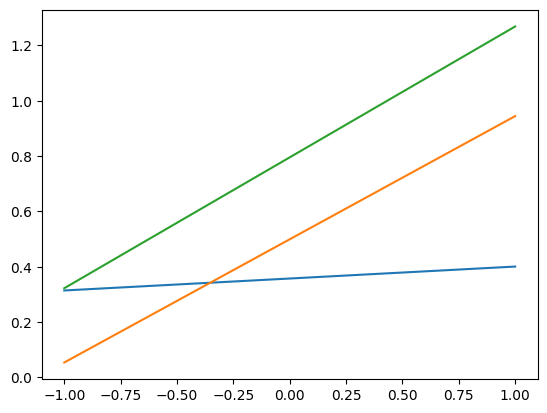

In [24]:
import numpy as np
import matplotlib.pyplot as plt

X = np.linspace(-1.0, 1.0, num=100).reshape(-1,1)
W = np.random.rand(3,1)
b = np.random.rand(1,3)

h = X @ W.T + b

plt.plot(X.reshape(-1), h[:,0].reshape(-1), label='w1*x + b')
plt.plot(X.reshape(-1), h[:,1].reshape(-1), label='w2*x + b')
plt.plot(X.reshape(-1), h[:,2].reshape(-1), label='w3*x + b')
plt.show()


### Added stuff
- Now let's add a training loop here to observe each linear regions

In [27]:
import jax.numpy as jnp
from jax import grad, jit, vmap, jacobian
from jax import random
from jaxlib.xla_extension import ArrayImpl
import math
from jax.scipy.special import logsumexp


# A helper function to randomly initialize weights and biases
# for a dense neural network layer
def random_layer_params(m, n, key, scale=1e-2):
  w_key, b_key = random.split(key)
  return scale * random.normal(w_key, (m, n)), scale * random.normal(b_key, (n,))

# Initialize all layers for a fully-connected neural network with sizes "sizes"
def init_network_params(net_sizes, key):
  keys = random.split(key, len(net_sizes))
  return [
     random_layer_params(m, n, k) 
     for (m,n), k in zip(net_sizes, keys)
   ]

def display_params(params, params_name):
   print(f'{params_name} total num_layers = ', len(params))
   for level, param in enumerate(params, start=1):
      weight_shape = param[0].shape
      bias_shape = param[1].shape
      print(f'({level}) {params_name}_weights.shape = {weight_shape}, {params_name}_bias.shape = {bias_shape}')



In [28]:
def relu(x):
    return jnp.max(0, x)

def mse(y_pred,y_target):
    return jnp.mean((y_pred - y_target) ** 2)

def linear(W, x):
    return x @ W

def predict(params, x_input):
    activations = x_input 
    for w, b in params[:-1]:
        outputs = activations @ w + b
        activations = relu(outputs)
    
    final_w = params[-1][0]
    final_b = params[-1][1]

    logits = activations @ final_w + final_b
    return jnp.tanh(logits)

@jit
def loss_func(params, x_input, targets):
  preds = predict(params, x_input)
  return mse(preds, targets)

In [39]:
import numpy as np
import math

def generate_sine_data(num_samples):
  X = jnp.linspace(0, 2 * math.pi, num=num_samples).reshape(-1,1)
  y = jnp.sin(X)
  return X,y

def update_weights(params, x, y, learning_rate):
  grads = grad(loss_func)(params, x, y)
  return [(w - learning_rate * dw, b - learning_rate * db)
          for (w, b), (dw, db) in zip(params, grads)]

def train_network(params, num_samples, num_epochs, step_display):
  learning_rate = 0.01
  X,y = generate_sine_data(num_samples)

  for curr_epoch in range(1, num_epochs + 1):
    loss = loss_func(params, X, y)
    params = update_weights(params, X, y, learning_rate)
    if curr_epoch % step_display == 0:
      print(f'[{curr_epoch}/{num_epochs}] Loss: {loss}')

  return params

def parameter_sizes(params):
  layer_depth = len(params)
  for layer_num, layer in enumerate(params, start=1):
    weight_dims = layer[0].shape
    bias_dims = layer[1].shape
    print(f'[{layer_num}/{layer_depth}] weight_dims = {weight_dims}, bias_dims = {bias_dims}')

# Network initial parameters
num_hidden = 10
net_sizes = [
  (1, num_hidden),
  (num_hidden, 1),
]

random_seed = np.random.randint(0, 1024)
params = init_network_params(net_sizes, random.PRNGKey(random_seed))
parameter_sizes(params)

[1/2] weight_dims = (1, 10), bias_dims = (10,)
[2/2] weight_dims = (10, 1), bias_dims = (1,)


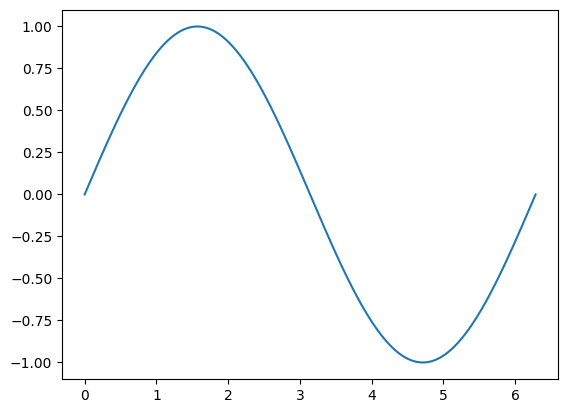

In [36]:
import matplotlib.pyplot as plt

X,y = generate_sine_data(1000)
plt.plot(X.reshape(-1), y.reshape(-1))
plt.show()
# print(X.shape)
# print(y.shape)